https://www.kaggle.com/code/dimakyn/pytorch-unet

In [1]:
# import the necessary packages
import os
import time

import cv2
import zipfile

import torch
from torch.nn import ReLU
from torch.nn import Conv2d
from torch.nn import Module
from torch.optim import Adam
from torch.nn import MaxPool2d
from torch.nn import ModuleList
from torchvision import transforms
from torch.utils.data import Dataset
from torch.nn import ConvTranspose2d
from torch.nn import functional as F
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader
from torchvision.transforms import CenterCrop

from sklearn.model_selection import train_test_split


from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
os.chdir('DefectData')

In [2]:
class DefectDataset(Dataset):
    def __init__(self, dir, transforms):
        self.root = ''
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imagePaths = list(sorted(glob('./{}/[0-9][0-9][0-9][0-9][0-9].png'.format(dir))))
        self.maskPaths = list(sorted(glob('./{}/[0-9][0-9][0-9][0-9][0-9]_GT.png'.format(dir))))

        if transforms!=None:
          self.transforms = transforms

    def __getitem__(self, idx):
        # load images ad masks
        #print('idx:', idx)
        img_path = os.path.join(self.root, self.imagePaths[idx])
        #print('img_path', self.imgs[idx])
        mask_path = os.path.join(self.root, self.maskPaths[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = cv2.imread(mask_path, 0)

        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            mask = self.transforms(mask)

        return (image, mask)
    
    def __len__(self):
        return len(self.imagePaths)

In [3]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
        
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

In [4]:
class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList([Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
        
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
        
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
            
        # return the list containing the intermediate outputs
		return blockOutputs

In [5]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
        
		# initialize the number of channels, upsampler blocks, and decoder blocks
		self.channels = channels
		self.upconvs = ModuleList([ConvTranspose2d(channels[i], channels[i + 1], 2, 2) for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList([Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
        
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
            
			# crop the current features from the encoder blocks, concatenate them with the current upsampled features,
			# and pass the concatenated output through the current decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
            
		# return the final decoder output
		return x
    
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
        
		# return the cropped features
		return encFeatures

In [6]:
class UNet(Module):
	def __init__(self, encChannels=(3, 16, 32, 64), decChannels=(64, 32, 16), nbClasses=1, retainDim=True, outSize=(636, 231)):
		super().__init__()
		
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
		
		# initialize the regression head and store the class variables
		self.head = Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize
		
	def forward(self, x):
		# grab the features from the encoder
		encFeatures = self.encoder(x)
		
		# pass the encoder features through decoder making sure that their dimensions are suited for concatenation
		decFeatures = self.decoder(encFeatures[::-1][0],encFeatures[::-1][1:])
		
		# pass the decoder features through the regression head to obtain the segmentation mask
		map_ = self.head(decFeatures)
		
		# check to see if we are retaining the original output dimensions and if so, then resize the output to match them
		if self.retainDim:
			map_ = F.interpolate(map_, self.outSize)
			
		# return the segmentation map
		return map_

In [8]:
from torchvision import transforms
batch_size = 16
num_epochs = 100
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((636,231)), transforms.ToTensor()])
dataset = DefectDataset('train', transform)

trainLoader = DataLoader(dataset, shuffle=True,	batch_size=batch_size)

unet = UNet().to(device)

# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=5e-5)

# calculate steps per epoch for training and test set
trainSteps = len(dataset) // batch_size

In [8]:
train_loss = []
startTime = time.time()
for e in tqdm(range(num_epochs)):
	# set the model in training mode
	unet.train()
    
	# initialize the total training and validation loss
	totalTrainLoss = 0
    
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
        
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
        
		# first, zero out any previously accumulated gradients, then perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
        
		# add the loss to the total training loss so far
		totalTrainLoss += loss
        
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
            
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps

	train_loss.append(avgTrainLoss.cpu().detach().numpy())
    
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
	print("Train loss: {:.6f}".format(avgTrainLoss))
    
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

  1%|          | 1/100 [00:13<22:58, 13.92s/it]

[INFO] EPOCH: 1/100
Train loss: 0.421584


  2%|▏         | 2/100 [00:27<22:03, 13.50s/it]

[INFO] EPOCH: 2/100
Train loss: 0.020432


  3%|▎         | 3/100 [00:40<21:35, 13.36s/it]

[INFO] EPOCH: 3/100
Train loss: 0.020121


  4%|▍         | 4/100 [00:53<21:21, 13.34s/it]

[INFO] EPOCH: 4/100
Train loss: 0.020181


  5%|▌         | 5/100 [01:06<21:05, 13.33s/it]

[INFO] EPOCH: 5/100
Train loss: 0.019697


  6%|▌         | 6/100 [01:20<20:44, 13.24s/it]

[INFO] EPOCH: 6/100
Train loss: 0.019550


  7%|▋         | 7/100 [01:33<20:28, 13.21s/it]

[INFO] EPOCH: 7/100
Train loss: 0.019530


  8%|▊         | 8/100 [01:46<20:10, 13.15s/it]

[INFO] EPOCH: 8/100
Train loss: 0.019221


  9%|▉         | 9/100 [01:59<20:04, 13.24s/it]

[INFO] EPOCH: 9/100
Train loss: 0.018673


 10%|█         | 10/100 [02:12<19:48, 13.21s/it]

[INFO] EPOCH: 10/100
Train loss: 0.018007


 11%|█         | 11/100 [02:26<19:39, 13.26s/it]

[INFO] EPOCH: 11/100
Train loss: 0.017270


 12%|█▏        | 12/100 [02:39<19:24, 13.24s/it]

[INFO] EPOCH: 12/100
Train loss: 0.016610


 13%|█▎        | 13/100 [02:52<19:05, 13.17s/it]

[INFO] EPOCH: 13/100
Train loss: 0.016086


 14%|█▍        | 14/100 [03:05<18:55, 13.20s/it]

[INFO] EPOCH: 14/100
Train loss: 0.015430


 15%|█▌        | 15/100 [03:18<18:46, 13.25s/it]

[INFO] EPOCH: 15/100
Train loss: 0.015232


 16%|█▌        | 16/100 [03:32<18:29, 13.20s/it]

[INFO] EPOCH: 16/100
Train loss: 0.014932


 17%|█▋        | 17/100 [03:45<18:10, 13.14s/it]

[INFO] EPOCH: 17/100
Train loss: 0.014958


 18%|█▊        | 18/100 [03:58<18:01, 13.19s/it]

[INFO] EPOCH: 18/100
Train loss: 0.014385


 19%|█▉        | 19/100 [04:11<17:53, 13.25s/it]

[INFO] EPOCH: 19/100
Train loss: 0.014267


 20%|██        | 20/100 [04:25<17:50, 13.39s/it]

[INFO] EPOCH: 20/100
Train loss: 0.014242


 21%|██        | 21/100 [04:38<17:34, 13.35s/it]

[INFO] EPOCH: 21/100
Train loss: 0.014338


 22%|██▏       | 22/100 [04:51<17:15, 13.27s/it]

[INFO] EPOCH: 22/100
Train loss: 0.014184


 23%|██▎       | 23/100 [05:04<16:52, 13.15s/it]

[INFO] EPOCH: 23/100
Train loss: 0.013890


 24%|██▍       | 24/100 [05:17<16:37, 13.12s/it]

[INFO] EPOCH: 24/100
Train loss: 0.013990


 25%|██▌       | 25/100 [05:30<16:26, 13.15s/it]

[INFO] EPOCH: 25/100
Train loss: 0.013473


 26%|██▌       | 26/100 [05:43<16:09, 13.11s/it]

[INFO] EPOCH: 26/100
Train loss: 0.013062


 27%|██▋       | 27/100 [05:57<15:58, 13.13s/it]

[INFO] EPOCH: 27/100
Train loss: 0.013168


 28%|██▊       | 28/100 [06:10<15:45, 13.14s/it]

[INFO] EPOCH: 28/100
Train loss: 0.013203


 29%|██▉       | 29/100 [06:23<15:31, 13.12s/it]

[INFO] EPOCH: 29/100
Train loss: 0.012983


 30%|███       | 30/100 [06:36<15:16, 13.09s/it]

[INFO] EPOCH: 30/100
Train loss: 0.012705


 31%|███       | 31/100 [06:49<15:03, 13.10s/it]

[INFO] EPOCH: 31/100
Train loss: 0.012940


 32%|███▏      | 32/100 [07:02<14:53, 13.14s/it]

[INFO] EPOCH: 32/100
Train loss: 0.012773


 33%|███▎      | 33/100 [07:15<14:40, 13.13s/it]

[INFO] EPOCH: 33/100
Train loss: 0.013058


 34%|███▍      | 34/100 [07:29<14:30, 13.19s/it]

[INFO] EPOCH: 34/100
Train loss: 0.013106


 35%|███▌      | 35/100 [07:42<14:12, 13.12s/it]

[INFO] EPOCH: 35/100
Train loss: 0.012709


 36%|███▌      | 36/100 [07:54<13:52, 13.01s/it]

[INFO] EPOCH: 36/100
Train loss: 0.013115


 37%|███▋      | 37/100 [08:07<13:40, 13.02s/it]

[INFO] EPOCH: 37/100
Train loss: 0.012375


 38%|███▊      | 38/100 [08:21<13:30, 13.07s/it]

[INFO] EPOCH: 38/100
Train loss: 0.012465


 39%|███▉      | 39/100 [08:34<13:20, 13.12s/it]

[INFO] EPOCH: 39/100
Train loss: 0.012754


 40%|████      | 40/100 [08:47<13:05, 13.09s/it]

[INFO] EPOCH: 40/100
Train loss: 0.012849


 41%|████      | 41/100 [09:00<12:52, 13.10s/it]

[INFO] EPOCH: 41/100
Train loss: 0.012885


 42%|████▏     | 42/100 [09:13<12:35, 13.03s/it]

[INFO] EPOCH: 42/100
Train loss: 0.012186


 43%|████▎     | 43/100 [09:26<12:23, 13.05s/it]

[INFO] EPOCH: 43/100
Train loss: 0.012774


 44%|████▍     | 44/100 [09:39<12:16, 13.15s/it]

[INFO] EPOCH: 44/100
Train loss: 0.012197


 45%|████▌     | 45/100 [09:52<12:02, 13.14s/it]

[INFO] EPOCH: 45/100
Train loss: 0.012321


 46%|████▌     | 46/100 [10:06<11:48, 13.12s/it]

[INFO] EPOCH: 46/100
Train loss: 0.012206


 47%|████▋     | 47/100 [10:19<11:39, 13.19s/it]

[INFO] EPOCH: 47/100
Train loss: 0.012186


 48%|████▊     | 48/100 [10:32<11:24, 13.16s/it]

[INFO] EPOCH: 48/100
Train loss: 0.012371


 49%|████▉     | 49/100 [10:45<11:08, 13.10s/it]

[INFO] EPOCH: 49/100
Train loss: 0.012156


 50%|█████     | 50/100 [10:58<10:52, 13.05s/it]

[INFO] EPOCH: 50/100
Train loss: 0.012232


 51%|█████     | 51/100 [11:11<10:44, 13.15s/it]

[INFO] EPOCH: 51/100
Train loss: 0.012317


 52%|█████▏    | 52/100 [11:24<10:27, 13.08s/it]

[INFO] EPOCH: 52/100
Train loss: 0.012136


 53%|█████▎    | 53/100 [11:37<10:15, 13.09s/it]

[INFO] EPOCH: 53/100
Train loss: 0.012246


 54%|█████▍    | 54/100 [11:50<09:58, 13.02s/it]

[INFO] EPOCH: 54/100
Train loss: 0.012263


 55%|█████▌    | 55/100 [12:03<09:44, 13.00s/it]

[INFO] EPOCH: 55/100
Train loss: 0.012117


 56%|█████▌    | 56/100 [12:16<09:33, 13.03s/it]

[INFO] EPOCH: 56/100
Train loss: 0.012239


 57%|█████▋    | 57/100 [12:29<09:19, 13.01s/it]

[INFO] EPOCH: 57/100
Train loss: 0.011949


 58%|█████▊    | 58/100 [12:42<09:08, 13.05s/it]

[INFO] EPOCH: 58/100
Train loss: 0.011691


 59%|█████▉    | 59/100 [12:56<09:02, 13.24s/it]

[INFO] EPOCH: 59/100
Train loss: 0.011789


 60%|██████    | 60/100 [13:10<08:55, 13.38s/it]

[INFO] EPOCH: 60/100
Train loss: 0.012258


 61%|██████    | 61/100 [13:23<08:43, 13.42s/it]

[INFO] EPOCH: 61/100
Train loss: 0.011865


 62%|██████▏   | 62/100 [13:37<08:36, 13.60s/it]

[INFO] EPOCH: 62/100
Train loss: 0.011751


 63%|██████▎   | 63/100 [13:51<08:21, 13.57s/it]

[INFO] EPOCH: 63/100
Train loss: 0.011616


 64%|██████▍   | 64/100 [14:04<08:08, 13.57s/it]

[INFO] EPOCH: 64/100
Train loss: 0.011747


 65%|██████▌   | 65/100 [14:18<08:00, 13.72s/it]

[INFO] EPOCH: 65/100
Train loss: 0.011580


 66%|██████▌   | 66/100 [14:31<07:40, 13.54s/it]

[INFO] EPOCH: 66/100
Train loss: 0.011656


 67%|██████▋   | 67/100 [14:45<07:28, 13.58s/it]

[INFO] EPOCH: 67/100
Train loss: 0.011775


 68%|██████▊   | 68/100 [14:59<07:21, 13.79s/it]

[INFO] EPOCH: 68/100
Train loss: 0.011591


 69%|██████▉   | 69/100 [15:13<07:05, 13.74s/it]

[INFO] EPOCH: 69/100
Train loss: 0.011860


 70%|███████   | 70/100 [15:26<06:44, 13.50s/it]

[INFO] EPOCH: 70/100
Train loss: 0.011661


 71%|███████   | 71/100 [15:39<06:25, 13.29s/it]

[INFO] EPOCH: 71/100
Train loss: 0.011338


 72%|███████▏  | 72/100 [15:52<06:10, 13.23s/it]

[INFO] EPOCH: 72/100
Train loss: 0.011761


 73%|███████▎  | 73/100 [16:05<05:54, 13.14s/it]

[INFO] EPOCH: 73/100
Train loss: 0.011593


 74%|███████▍  | 74/100 [16:18<05:40, 13.10s/it]

[INFO] EPOCH: 74/100
Train loss: 0.011893


 75%|███████▌  | 75/100 [16:31<05:31, 13.25s/it]

[INFO] EPOCH: 75/100
Train loss: 0.011710


 76%|███████▌  | 76/100 [16:45<05:17, 13.22s/it]

[INFO] EPOCH: 76/100
Train loss: 0.011708


 77%|███████▋  | 77/100 [16:58<05:03, 13.18s/it]

[INFO] EPOCH: 77/100
Train loss: 0.011499


 78%|███████▊  | 78/100 [17:11<04:49, 13.18s/it]

[INFO] EPOCH: 78/100
Train loss: 0.011307


 79%|███████▉  | 79/100 [17:24<04:38, 13.26s/it]

[INFO] EPOCH: 79/100
Train loss: 0.011358


 80%|████████  | 80/100 [17:37<04:23, 13.16s/it]

[INFO] EPOCH: 80/100
Train loss: 0.011387


 81%|████████  | 81/100 [17:51<04:11, 13.24s/it]

[INFO] EPOCH: 81/100
Train loss: 0.011420


 82%|████████▏ | 82/100 [18:04<03:58, 13.24s/it]

[INFO] EPOCH: 82/100
Train loss: 0.011448


 83%|████████▎ | 83/100 [18:17<03:45, 13.28s/it]

[INFO] EPOCH: 83/100
Train loss: 0.011564


 84%|████████▍ | 84/100 [18:31<03:33, 13.35s/it]

[INFO] EPOCH: 84/100
Train loss: 0.011289


 85%|████████▌ | 85/100 [18:44<03:19, 13.31s/it]

[INFO] EPOCH: 85/100
Train loss: 0.011234


 86%|████████▌ | 86/100 [18:57<03:06, 13.33s/it]

[INFO] EPOCH: 86/100
Train loss: 0.011479


 87%|████████▋ | 87/100 [19:11<02:52, 13.30s/it]

[INFO] EPOCH: 87/100
Train loss: 0.010970


 88%|████████▊ | 88/100 [19:24<02:40, 13.36s/it]

[INFO] EPOCH: 88/100
Train loss: 0.011132


 89%|████████▉ | 89/100 [19:37<02:25, 13.25s/it]

[INFO] EPOCH: 89/100
Train loss: 0.011353


 90%|█████████ | 90/100 [19:50<02:12, 13.29s/it]

[INFO] EPOCH: 90/100
Train loss: 0.011039


 91%|█████████ | 91/100 [20:09<02:13, 14.81s/it]

[INFO] EPOCH: 91/100
Train loss: 0.011042


 92%|█████████▏| 92/100 [20:23<01:58, 14.76s/it]

[INFO] EPOCH: 92/100
Train loss: 0.011334


 93%|█████████▎| 93/100 [20:37<01:39, 14.27s/it]

[INFO] EPOCH: 93/100
Train loss: 0.011400


 94%|█████████▍| 94/100 [20:50<01:24, 14.03s/it]

[INFO] EPOCH: 94/100
Train loss: 0.011187


 95%|█████████▌| 95/100 [21:03<01:08, 13.73s/it]

[INFO] EPOCH: 95/100
Train loss: 0.010977


 96%|█████████▌| 96/100 [21:21<01:00, 15.01s/it]

[INFO] EPOCH: 96/100
Train loss: 0.011124


 97%|█████████▋| 97/100 [21:39<00:47, 15.91s/it]

[INFO] EPOCH: 97/100
Train loss: 0.011519


 98%|█████████▊| 98/100 [21:52<00:29, 14.97s/it]

[INFO] EPOCH: 98/100
Train loss: 0.011320


 99%|█████████▉| 99/100 [22:05<00:14, 14.35s/it]

[INFO] EPOCH: 99/100
Train loss: 0.011248


100%|██████████| 100/100 [22:19<00:00, 13.40s/it]

[INFO] EPOCH: 100/100
Train loss: 0.011028
[INFO] total time taken to train the model: 1339.83s


In [9]:
def make_predictions(model, image, mask):
	# set model to evaluation mode
	model.eval()

	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it to float data type, and scale its pixel values
		image = cv2.imread(image)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0

		# resize the image and make a copy of it for visualization
		#image = cv2.resize(image, (128, 128))
		orig = image.copy()

		# load the ground-truth segmentation mask in grayscale mode and resize it
		gtMask = cv2.imread(mask, 0)
		gtMask = cv2.resize(gtMask, (636, 231))
        
        # make the channel axis to be the leading one, add a batch dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(device)

		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()
		
		# filter out the weak predictions and convert them to integers
		predMask = (predMask > .1)*255
		predMask = predMask.astype(np.uint8)
	return predMask

0.027130126953125


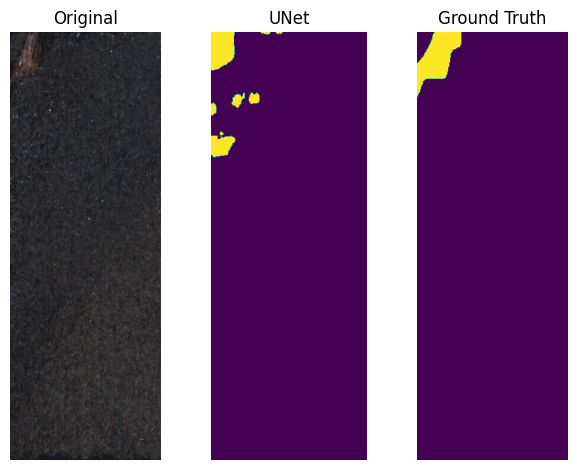

In [11]:
import torch
from torchvision import transforms
from PIL import Image
import time

unet = torch.load('unet.pt', map_location='cpu')
start = time.time()
predmask = make_predictions(unet, 'train/10021.png', 'train/10021_GT.png')
print(time.time()-start)

plt.figure()
plt.subplot(131)
img = Image.open('train/10021.png')
plt.imshow(img)
plt.axis('off')
plt.title('Original')

plt.subplot(132)
plt.imshow(predmask)
plt.axis('off')
plt.title('UNet')

plt.subplot(133)
mask = Image.open('train/10021_GT.png')
plt.imshow(mask)

plt.axis('off')
plt.title('Ground Truth')

plt.tight_layout()




In [16]:
torch.save(unet, 'unet.pt')
np.save('unet_loss.npy',np.array(train_loss))


In [17]:
ious = []
testimages = list(sorted(glob('./test/[0-9][0-9][0-9][0-9][0-9].png')))
testimages.sort()
testmasks = list(sorted(glob('./test/[0-9][0-9][0-9][0-9][0-9]_GT.png')))
testmasks.sort()

for i, fpath in enumerate(tqdm(testimages)):
    predmask = make_predictions(unet, fpath, testmasks[i])/255
    predmask = predmask.astype(int)
    masks = cv2.imread(testmasks[i], 0)/255
    masks = np.resize(masks.astype(int), predmask.shape)
    intersection = np.sum(masks&predmask)
    union = np.sum(masks|predmask)
    if union>0:
        ious.append(float(intersection)/union)
    else:
        ious.append(1)

100%|██████████| 1004/1004 [00:05<00:00, 192.48it/s]


In [18]:
print(np.average(ious))

0.7152624053942627
